In [ ]:
# Read in and clean data

import io
from google.colab import files
uploaded = files.upload()

import nltk
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import string

nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

messages = pd.read_csv('spam.csv', encoding='latin-1')
messages = messages.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
messages.columns = ["label", "text"]
messages['label'] = np.where(messages['label']=='spam', 1, 0)

def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [word for word in tokens if word not in stopwords]
    return text

messages['clean_text'] = messages['text'].apply(lambda x: clean_text(x))
messages.head()

Saving spam.csv to spam.csv
Saving X_test.csv to X_test.csv
Saving X_train.csv to X_train.csv
Saving y_test.csv to y_test.csv
Saving y_train.csv to y_train.csv
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,label,text,clean_text
0,0,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazy, available, bugis, n..."
1,0,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,0,U dun say so early hor... U c already then say...,"[u, dun, say, early, hor, u, c, already, say]"
4,0,"Nah I don't think he goes to usf, he lives aro...","[nah, dont, think, goes, usf, lives, around, t..."


In [ ]:
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(messages['clean_text'],
                                                    messages['label'], test_size=0.2)

X_train[:]
y_train[:10]

3242    0
4613    0
200     0
1846    0
217     0
5204    0
4383    0
682     0
2415    0
4920    0
Name: label, dtype: int64

In [ ]:
X_train.to_csv('X_train.csv', index=False, header=True)
X_test.to_csv('X_test.csv', index=False, header=True)
y_train.to_csv('y_train.csv', index=False, header=True)
y_test.to_csv('y_test.csv', index=False, header=True)

# Tf-IDF Embedding

In [ ]:
# Load the cleaned training and test sets
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

X_train.head()


,clean_text
0,"['pls', 'accept', 'one', 'day', 'begging', 'ch..."
1,"['hows', 'favourite', 'person', 'today', 'r', ..."
2,"['sent', 'ltgt', 'bucks']"
3,"['engalnd', 'telly', 'decided', 'wont', 'let',..."
4,"['easy', 'ahsen', 'got', 'selected', 'means', ..."


In [ ]:
# Instantiate and fit a TFIDF vectorizer and then use that trained vectorizer
# to transform the messages in the training and test sets
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(X_train['clean_text'])
X_train_vect = tfidf_vect.transform(X_train['clean_text'])
X_test_vect = tfidf_vect.transform(X_test['clean_text'])

In [ ]:
tfidf_vect.vocabulary_

X_test_vect[0]
X_test_vect[0].toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# Random Forest Classifier on model
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf_model = rf.fit(X_train_vect, y_train.values.ravel())

In [ ]:
# Use the trained model to make predictions on the test data
y_pred = rf_model.predict(X_test_vect)

In [ ]:
# Evaluate the predictions of the model on the holdout test set
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round((y_pred==y_test['label']).sum()/len(y_pred), 3)))

Precision: 1.0 / Recall: 0.812 / Accuracy: 0.973


In [ ]:
# Instantiate and fit a TFIDF vectorizer and then use that trained vectorizer
# to transform the messages in the training and test sets
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(X_train['clean_text'])
X_train_vect = tfidf_vect.transform(X_train['clean_text'])
X_test_vect = tfidf_vect.transform(X_test['clean_text'])

# Word2-Vec Embedding

In [ ]:
# Load the cleaned training and test sets
import gensim
import numpy as np
import pandas as pd

X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

X_train.head()

,clean_text
0,"['pls', 'accept', 'one', 'day', 'begging', 'ch..."
1,"['hows', 'favourite', 'person', 'today', 'r', ..."
2,"['sent', 'ltgt', 'bucks']"
3,"['engalnd', 'telly', 'decided', 'wont', 'let',..."
4,"['easy', 'ahsen', 'got', 'selected', 'means', ..."


In [ ]:
# Train a basic word2vec model
w2v_model = gensim.models.Word2Vec(X_train,
                                   size=100,
                                   window=5,
                                   min_count=2)

In [ ]:
# Replace the words in each text message with the learned word vector
words = set(w2v_model.wv.index2word)
X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_train['clean_text']])
X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_test['clean_text']])

In [ ]:
# Average the word vectors for each sentence (and assign a vector of zeros if the model
# did not learn any of the words in the text message during training
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))
        
X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(100, dtype=float))

In [ ]:
X_train_vect[0]

array([[ 8.1987621e-04,  2.3818112e-03, -2.9777496e-03, -5.2963092e-04,
        -3.3515536e-03,  3.3166863e-03,  2.2624165e-03,  3.3559178e-03,
        -3.7332720e-03,  1.5694392e-03,  3.4957977e-03,  1.3440943e-03,
         3.2505448e-04, -4.8386422e-03, -7.1138423e-04,  1.6191546e-03,
        -3.5697054e-03,  4.8921336e-03, -4.8299134e-03,  4.2894538e-03,
         2.9227014e-03, -3.4072238e-03,  2.4859291e-03, -2.2999798e-03,
         4.8154700e-03, -2.5901441e-03,  4.7749234e-03, -1.3979864e-03,
        -7.4551528e-04, -2.1103059e-03, -8.6623506e-04,  4.0371115e-03,
        -3.3676913e-03,  1.4209012e-03, -2.4762359e-03,  3.1111173e-03,
        -1.5656339e-04,  3.4181019e-03,  1.2699701e-03, -1.2477832e-03,
         4.9269702e-03,  2.4053410e-03,  1.9048796e-04, -1.0019782e-03,
         2.2170083e-03,  3.7691384e-03, -8.7282569e-05,  4.2459220e-03,
        -4.1917949e-03,  5.4249336e-05,  1.0712908e-03, -3.1590208e-03,
         3.5361964e-03,  3.3352256e-03, -4.9199834e-03, -1.77751

In [ ]:
X_train_vect_avg[0]

array([ 6.06128015e-04,  1.33816665e-03, -2.69646593e-03,  2.24412070e-04,
       -1.98790734e-03,  3.09314649e-03,  1.69554353e-03,  2.43377173e-03,
       -2.59418529e-03,  5.10149635e-04,  3.24362400e-03,  1.69754459e-03,
        6.92152162e-06, -3.41624045e-03, -1.66802245e-04,  1.44835876e-03,
       -3.05932038e-03,  3.65790445e-03, -4.24616504e-03,  3.32968286e-03,
        1.84304209e-03, -2.26063235e-03,  2.36904458e-03, -1.19436113e-03,
        4.83543100e-03, -2.91567226e-03,  3.97981005e-03, -1.97801297e-03,
        1.76033776e-04, -2.54892348e-03, -4.28094529e-04,  3.40962666e-03,
       -2.59973551e-03,  6.73776201e-04, -2.56880163e-03,  1.98240508e-03,
        4.69480496e-04,  3.51613318e-03,  1.88029371e-03, -1.03847112e-03,
        3.59222572e-03,  2.63778213e-03,  7.76565692e-04, -8.61728113e-05,
        1.08044699e-03,  2.65107304e-03, -6.64264895e-04,  4.25023539e-03,
       -3.74681200e-03, -1.06724736e-04,  4.75732610e-04, -2.60135182e-03,
        2.85860081e-03,  

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf_model = rf.fit(X_train_vect_avg, y_train.values.ravel())

In [ ]:
y_pred = rf_model.predict(X_test_vect_avg)

In [ ]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round((y_pred==y_test['label']).sum()/len(y_pred), 3)))

Precision: 0.5 / Recall: 0.231 / Accuracy: 0.857


# RNN Model

In [ ]:
# Load the cleaned training and test sets
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# import pandas as pd

import io
from google.colab import files
uploaded = files.upload()

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K

X_train = pd.read_csv(io.BytesIO(uploaded['X_train.csv']))
X_test = pd.read_csv(io.BytesIO(uploaded['X_test.csv']))
y_train = pd.read_csv(io.BytesIO(uploaded['y_train.csv']))
y_test = pd.read_csv(io.BytesIO(uploaded['y_test.csv']))

Saving spam.csv to spam (1).csv
Saving X_test.csv to X_test (1).csv
Saving X_train.csv to X_train (1).csv
Saving y_test.csv to y_test (1).csv
Saving y_train.csv to y_train (1).csv


In [ ]:
print(X_train)

                                             clean_text
0            ['kkwhy', 'cant', 'come', 'search', 'job']
1     ['yup', 'hey', 'one', 'day', 'fri', 'ask', 'mi...
2                    ['ya', 'even', 'cookies', 'jelly']
3     ['think', 'û', 'waiting', 'bus', 'inform', 'ge...
4               ['lol', 'mad', 'first', 'woke', 'gave']
...                                                 ...
4452         ['going', 'write', 'ccna', 'exam', 'week']
4453                         ['home', 'always', 'chat']
4454  ['urgent', 'mobile', '07808726822', 'awarded',...
4455                                  ['number', 'sir']
4456  ['dont', 'cancer', 'moms', 'making', 'big', 'd...

[4457 rows x 1 columns]


In [ ]:
# Train the tokenizer and use that tokenizer to convert the sentences to sequences of numbers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['clean_text'])
X_train_seq = tokenizer.texts_to_sequences(X_train['clean_text'])
X_test_seq = tokenizer.texts_to_sequences(X_test['clean_text'])

In [ ]:
X_train_seq_padded = pad_sequences(X_train_seq, 50)
X_test_seq_padded = pad_sequences(X_test_seq, 50)


def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(X_train['clean_text'])

one_hot_results = tokenizer.texts_to_matrix(X_train['clean_text'], mode='binary')

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

model = Sequential()

model.add(Embedding(len(word_index)+1, 32))
model.add(LSTM(32, dropout=0, recurrent_dropout=0))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()



Found 8261 unique tokens.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          264384    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 273,793
Trainable params: 273,793
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# # Train the tokenizer and use that tokenizer to convert the sentences to sequences of numbers
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m])

In [ ]:
# Fit the RNN
history = model.fit(X_train_seq_padded, y_train['label'], 
                    batch_size=32, epochs=10,
                    validation_data=(X_test_seq_padded, y_test))

Epoch 1/10
140/140 [==============================] - 4s 30ms/step - loss: 0.2520 - accuracy: 0.9237 - precision_m: 0.5394 - recall_m: 0.4367 - val_loss: 0.0661 - val_accuracy: 0.9830 - val_precision_m: 0.9552 - val_recall_m: 0.8849
Epoch 2/10
140/140 [==============================] - 4s 27ms/step - loss: 0.0339 - accuracy: 0.9910 - precision_m: 0.9678 - recall_m: 0.9404 - val_loss: 0.0534 - val_accuracy: 0.9857 - val_precision_m: 0.9667 - val_recall_m: 0.8913
Epoch 3/10
140/140 [==============================] - 4s 28ms/step - loss: 0.0112 - accuracy: 0.9978 - precision_m: 0.9714 - recall_m: 0.9590 - val_loss: 0.0655 - val_accuracy: 0.9830 - val_precision_m: 0.9714 - val_recall_m: 0.8703
Epoch 4/10
140/140 [==============================] - 4s 26ms/step - loss: 0.0032 - accuracy: 0.9989 - precision_m: 0.9976 - recall_m: 0.9937 - val_loss: 0.0835 - val_accuracy: 0.9865 - val_precision_m: 1.0000 - val_recall_m: 0.9151
Epoch 5/10
140/140 [==============================] - 4s 27ms/step -

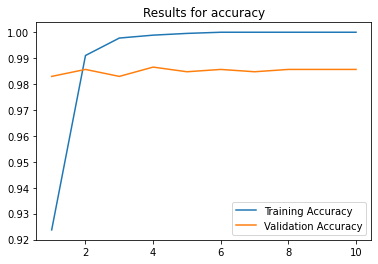

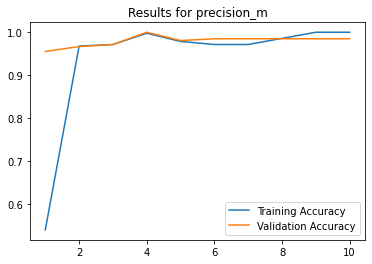

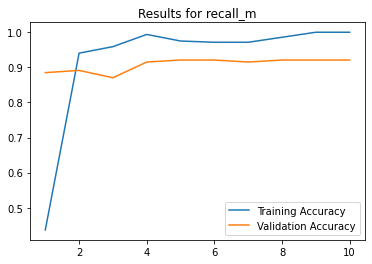

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

for i in ['accuracy', 'precision_m', 'recall_m']:
    acc = history.history[i]
    val_acc = history.history['val_{}'.format(i)]
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Results for {}'.format(i))
    plt.legend()
    plt.show()

# New Section